# MODELING PHASE

## Module mporting

In [10]:
import pandas as pd
from utils.essential import *
from utils.preparation import *
from utils.preparation_visualization import *
from utils.preparation_preprocessing import *

In [11]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# Google Drive access - (Uncoment if required)
#drive.mount('/content/drive')

path_df = '../data/2-features/marketing_campaign_data.csv' # - (Ensure path is correct)
#Dataframe definition
df = pd.read_csv(path_df, low_memory=False)
features= df.copy()

In [13]:
features

,Recency,Total_Purchases,Total_Spent,Total_AcceptedCmp
0,58,25,1617000,0
1,38,6,27000,0
2,26,21,776000,0
3,26,8,53000,0
4,94,19,422000,0
...,...,...,...,...
2235,46,18,1341000,0
2236,56,22,444000,1
2237,91,19,1241000,1
2238,8,23,843000,0


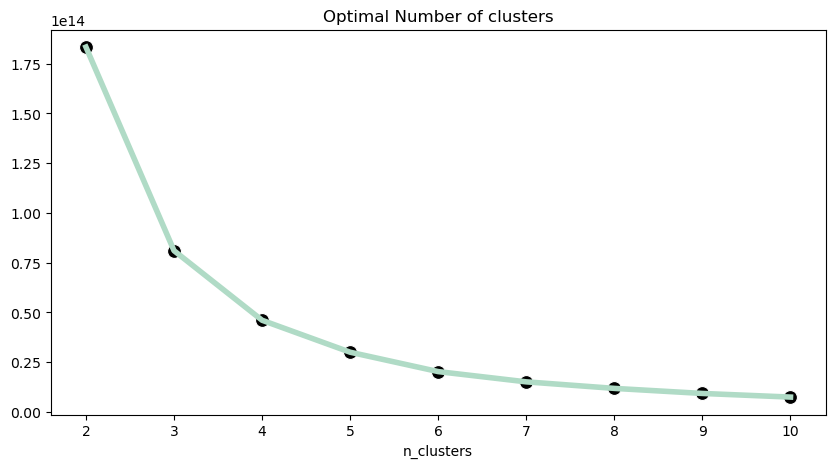

In [14]:
from sklearn.cluster import KMeans
inertia = []

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(features)
    inertia.append(kmeans.inertia_)



plt.figure(figsize=(10, 5))
plt.title('Optimal Number of clusters')
sns.lineplot(x=range(2, 11), y=inertia, linewidth = 4)
sns.scatterplot(x=range(2, 11), y=inertia, s=100, color='#000',  linestyle='-')
plt.xlabel('n_clusters')
plt.show()

   Recency  Total_Purchases  Total_Spent  Total_AcceptedCmp  Cluster
0       58               25      1617000                  0        0
1       38                6        27000                  0        2
2       26               21       776000                  0        1
3       26                8        53000                  0        2
4       94               19       422000                  0        1
--------------------------------------------------------------------------------
               PC1        PC2  Cluster
0     1.011202e+06   7.896205        0
1    -5.787982e+05 -10.531887        2
2     1.702018e+05 -23.288277        1
3    -5.527982e+05 -22.562008        2
4    -1.837982e+05  45.055510        1
...            ...        ...      ...
2235  7.352018e+05  -3.820946        3
2236 -1.617982e+05   7.026154        1
2237  6.352018e+05  41.271427        3
2238  2.372018e+05 -41.357477        3
2239 -4.337982e+05  -8.683859        2

[2240 rows x 3 columns]


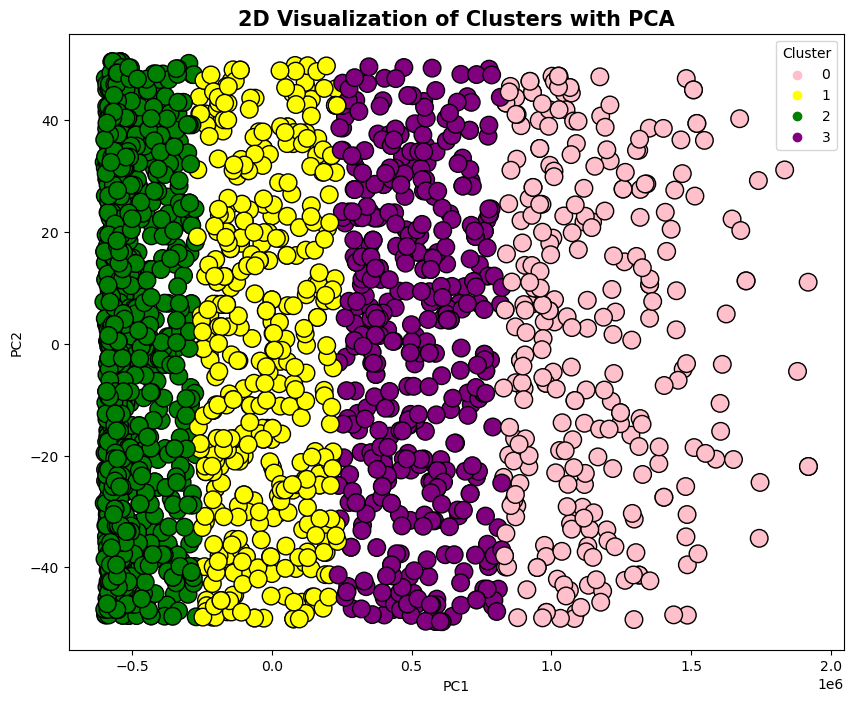

In [15]:
# Optimal number of clusters based on elbow method
optimal_clusters = 4  # Adjust based on the elbow observed

# Perform K-means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=0)
clusters = kmeans.fit_predict(features)

# Add cluster labels to the DataFrame
features['Cluster'] = clusters

print(features.head())
print("-"*80)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features)

# Create a DataFrame with PCA components and cluster labels
df_pca = pd.DataFrame(data=features_pca, columns=['PC1', 'PC2'])
df_pca['Cluster'] = features['Cluster']
print(df_pca)

# Visualize the clusters in 2D using PCA
fig, ax = plt.subplots(figsize=(10, 8))
plt.title("2D Visualization of Clusters with PCA", fontsize=15, weight='bold')
sns.scatterplot(
    x="PC1", y="PC2",
    hue="Cluster",
    edgecolor='black',
    data=df_pca,
    palette=['pink', 'yellow', 'green', 'purple'],
    s=160,
    ax=ax
)

plt.show()


Silhouette Score: 0.6516172734216132


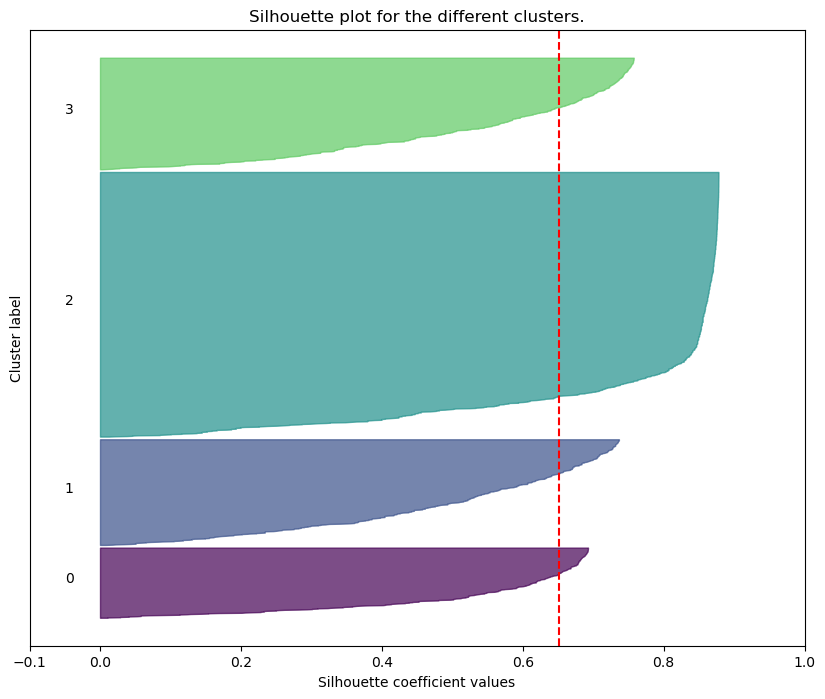

In [19]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import numpy as np

# Calculate silhouette score
silhouette_avg = silhouette_score(features_pca, clusters)

print(f'Silhouette Score: {silhouette_avg}')


# Calculate individual silhouette scores for each sample
sample_silhouette_values = silhouette_samples(features_pca, clusters)

# Visualize silhouette scores
fig, ax = plt.subplots(figsize=(10, 8))

y_lower = 10
for i in range(optimal_clusters):
    # Aggregate silhouette scores for samples in cluster i
    ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.viridis(float(i) / optimal_clusters)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for the next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax.set_title("Silhouette plot for the different clusters.")
ax.set_xlabel("Silhouette coefficient values")
ax.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax.axvline(x=silhouette_avg, color="red", linestyle="--")

ax.set_yticks([])  # Clear the yaxis labels / ticks
ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()


# ANALYSIS PHASE

In [59]:
summary_stats = features.groupby('Cluster').agg(['mean', 'median', 'max', 'min'])
# Display the summary statistics
summary_stats


Recency                Total_Purchases                 \
              mean median max min            mean median max min   
Cluster                                                            
0        51.361404   53.0  98   1       21.515789   22.0  44   1   
1        47.195804   46.0  99   0       19.694639   20.0  32   2   
2        49.101584   49.0  99   0        8.122088    7.0  27   0   
3        49.523179   53.0  99   0       22.064018   22.0  39  10   

          Total_Spent                              Total_AcceptedCmp         \
                 mean     median      max      min              mean median   
Cluster                                                                       
0        1.753589e+06  1690000.0  2525000  1435000          1.063158    1.0   
1        5.727902e+05   562000.0   841000   339000          0.226107    0.0   
2        1.004380e+05    66000.0   335000     5000          0.083877    0.0   
3        1.111960e+06  1102000.0  1429000   843000          0.390728    0.0   

                 
        max min  
Cluster          
0         4   0  
1         4   0  
2         2   0  
3         4   0

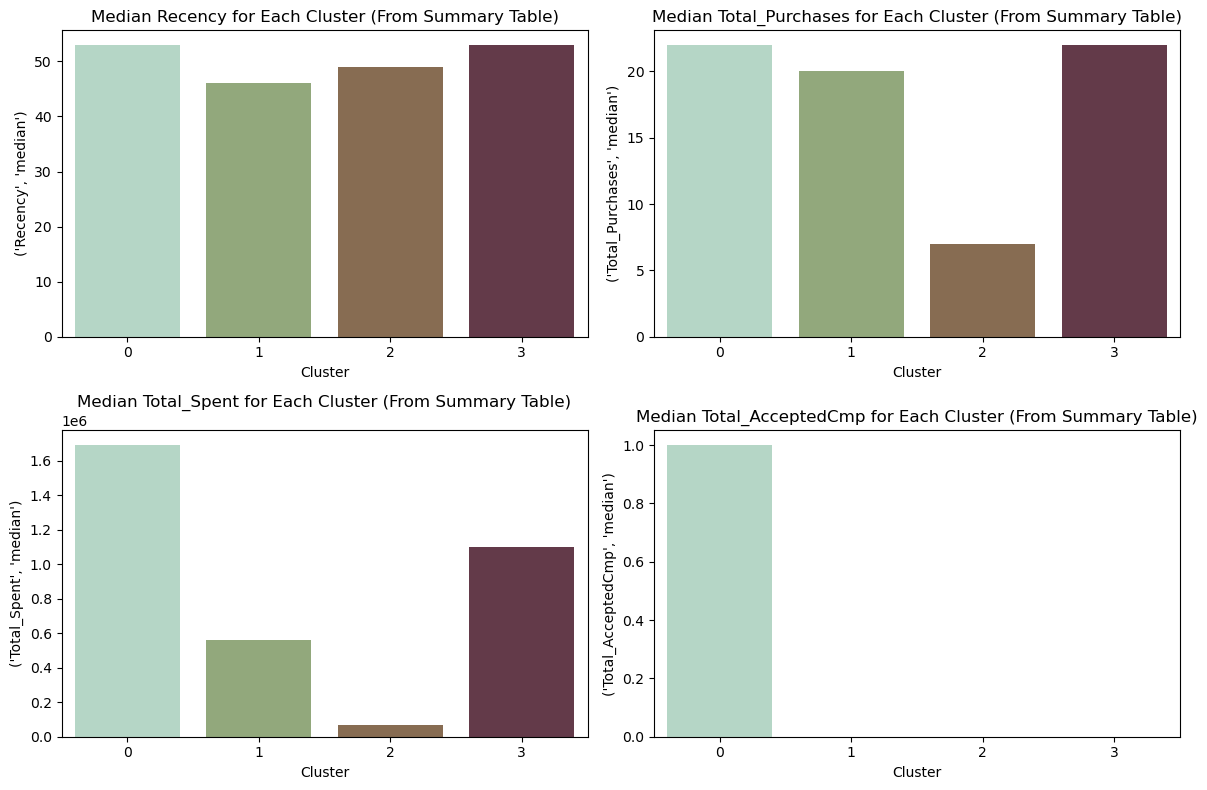

In [60]:
# Plot the mean of each column for each cluster using data from the summary table
plt.figure(figsize=(12, 8))
for column in summary_stats.columns.levels[0]:
    if column != 'Cluster':
        plt.subplot(2, 2, summary_stats.columns.levels[0].get_loc(column) + 1)
        sns.barplot(x=summary_stats.index, y=(column, 'median'), data=summary_stats)
        plt.title(f'Median {column} for Each Cluster (From Summary Table)')

plt.tight_layout()
plt.show()


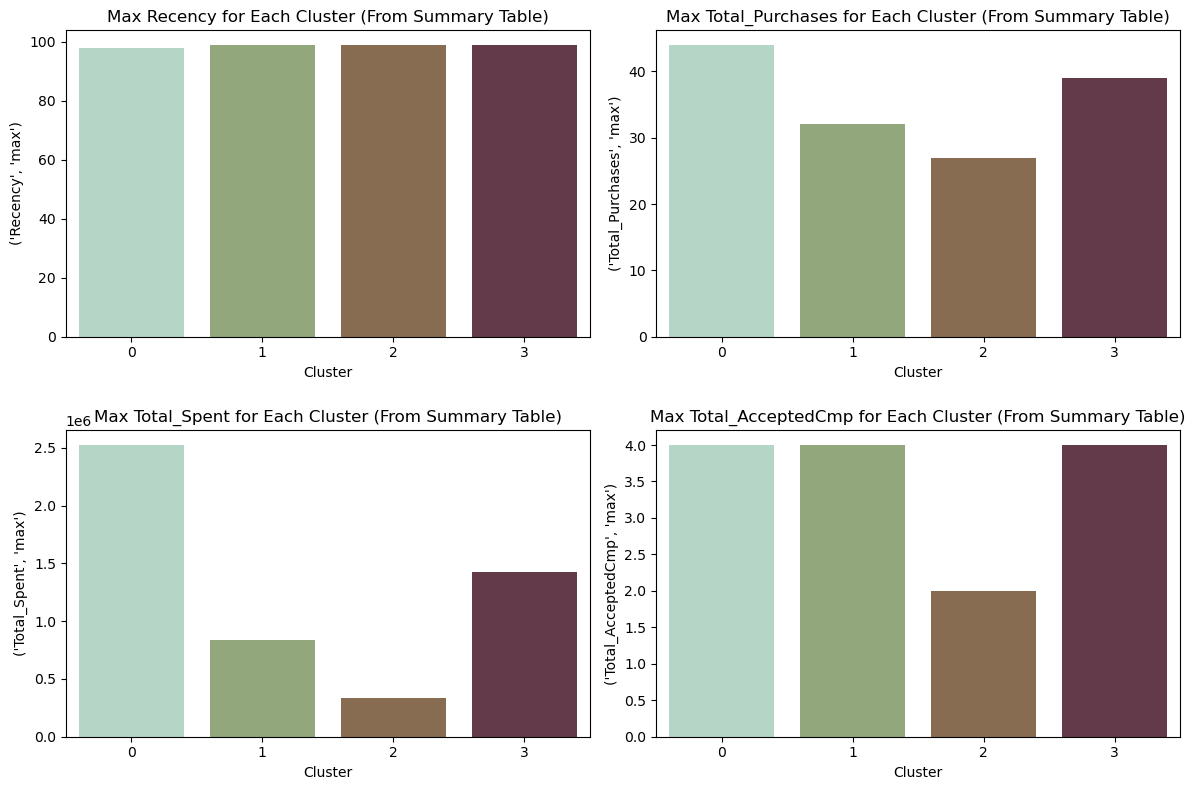

In [31]:
# Plot the mean of each column for each cluster using data from the summary table
plt.figure(figsize=(12, 8))
for column in summary_stats.columns.levels[0]:
    if column != 'Cluster':
        plt.subplot(2, 2, summary_stats.columns.levels[0].get_loc(column) + 1)
        sns.barplot(x=summary_stats.index, y=(column, 'max'), data=summary_stats)
        plt.title(f'Max {column} for Each Cluster (From Summary Table)')

plt.tight_layout()
plt.show()

In [37]:

# Get the total users in each cluster
cluster_users_count = features.groupby('Cluster').size().reset_index(name='Total Users')

# Display the result
print(cluster_users_count)


   Cluster  Total Users
0        0          285
1        1          429
2        2         1073
3        3          453


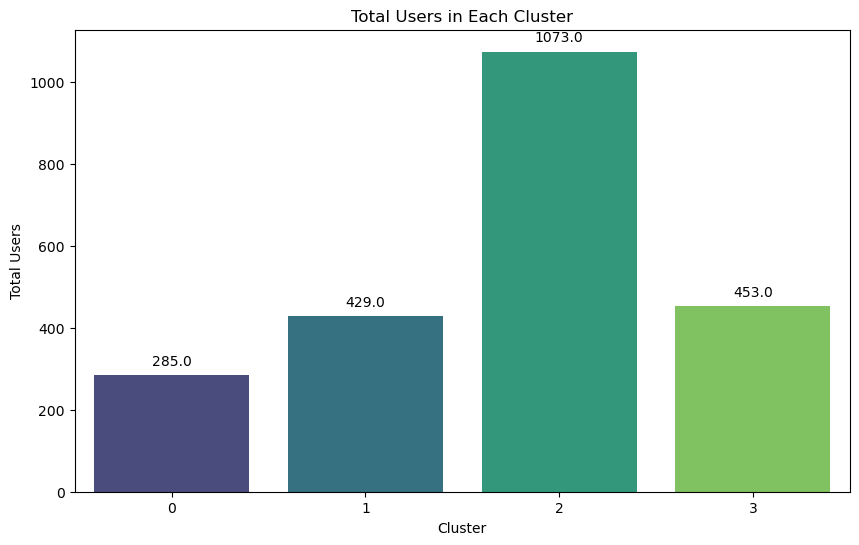

In [38]:
cluster_users_count = cluster_users_count.sort_values(by='Total Users', ascending=True)

# Plot the total users in each cluster
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Cluster', y='Total Users', data=cluster_users_count, palette='viridis')

# Display the number on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10)

plt.title('Total Users in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Total Users')
plt.show()

In [44]:
# Define thresholds for categorization
low_threshold = 500000
high_threshold = 1500000

# Categorize clusters based on 'Total_Spent'
summary_stats['Spent_Category'] = pd.cut(
    summary_stats[('Total_Spent', 'mean')],
    bins=[-float('inf'), low_threshold, high_threshold, float('inf')],
    labels=['Low', 'Medium', 'High']
)



In [50]:
# Define thresholds for categorization
low_purchases_threshold = summary_stats[('Total_Purchases', 'mean')].quantile(0.25)
high_purchases_threshold = summary_stats[('Total_Purchases', 'mean')].quantile(0.75)

# Categorize clusters based on 'Total_Purchases'
summary_stats['Purchases_Category'] = pd.cut(
    summary_stats[('Total_Purchases', 'mean')],
    bins=[-float('inf'), low_purchases_threshold, high_purchases_threshold, float('inf')],
    labels=['Low', 'Medium', 'High']
)

# Define thresholds for categorization
low_accepted_threshold = summary_stats[('Total_AcceptedCmp', 'mean')].quantile(0.25)
high_accepted_threshold = summary_stats[('Total_AcceptedCmp', 'mean')].quantile(0.75)

# Categorize clusters based on 'Total_AcceptedCmp'
summary_stats['AcceptedCmp_Category'] = pd.cut(
    summary_stats[('Total_AcceptedCmp', 'mean')],
    bins=[-float('inf'), low_accepted_threshold, high_accepted_threshold, float('inf')],
    labels=['Low', 'Medium', 'High']
)

# Define thresholds for categorization
low_recency_threshold = summary_stats[('Recency', 'mean')].quantile(0.25)
high_recency_threshold = summary_stats[('Recency', 'mean')].quantile(0.75)

# Categorize clusters based on 'Recency'
summary_stats['Recency_Category'] = pd.cut(
    summary_stats[('Recency', 'mean')],
    bins=[-float('inf'), low_recency_threshold, high_recency_threshold, float('inf')],
    labels=['Low', 'Medium', 'High']
)

# Display the result
summary_stats[['Purchases_Category', 'AcceptedCmp_Category', 'Recency_Category', 'Spent_Category']]


,Purchases_Category,AcceptedCmp_Category,Recency_Category,Spent_Category
,,,,
Cluster,,,,
0,Medium,High,High,High
1,Medium,Medium,Low,Medium
2,Low,Low,Medium,Low
3,High,Medium,Medium,Medium


Recency (R):
Recency Category: Represents different categories of engagement recency.

Frequency (F):
Purchases_Category and  AcceptedCmp Category: Represent different categories of purchase/acceptance frequency. Higher categories indicate higher frequency.

Monetary (M):
Spent_Category: Categorical representation of spending behavior. Higher categories indicate higher monetary contribution.

* Cluster 2: Low Engagement, Low Spending

Low Recency
Low Purchase Frequency
Medium Campaign Acceptance
Low Spending

* Cluster 1: Medium Engagement, Medium Spending

Medium Recency
Medium Purchase Frequency
Medium Campaign Acceptance
Medium Spending
Cluster 3: High Engagement, Medium Spending

High Recency
Medium Purchase Frequency
Medium Campaign Acceptance
Medium Spending

* Cluster 0: Very High Engagement, High Spending

High Recency
High Purchase Frequency
High Campaign Acceptance
High Spending

In [62]:
# Define a dictionary to map cluster names
cluster_label_mapping = {
    2: 'Low',
    1: 'Medium',
    3: 'High',
    0: 'Very High'
}

# Map cluster labels using the defined dictionary
summary_stats['Value'] = summary_stats.index.map(cluster_label_mapping.get)

# Display the result
print(summary_stats[['Value']])



             Value
                  
Cluster           
0        Very High
1           Medium
2              Low
3             High


# Recommendations

* Low Engagement, Low Spending (Cluster 2 - Low Value):

Business Recommendation: Develop strategies to increase engagement and encourage more frequent purchases. Implement targeted campaigns and incentives to win back their interest. Consider promotions to boost spending.


* Medium Engagement, Medium Spending (Cluster 1 - Medium Value):

Business Recommendation: Continue engaging with these customers through targeted campaigns. Encourage increased spending through personalized promotions. Explore ways to enhance their loyalty and satisfaction.


* High Engagement, Medium Spending (Cluster 3 - High Value):

Business Recommendation: Capitalize on the high engagement of these customers. Encourage them to increase their spending through personalized offers and promotions. Consider loyalty programs to enhance their long-term value.

* Very High Engagement, High Spending (Cluster 0 - Very High Value):

Business Recommendation: Focus on maintaining the high engagement of these customers. Consider premium offers and exclusive deals to further increase their spending. Implement loyalty programs to retain their loyalty.